# Entry Time Estimation
**NOTE**: data for this is stored locally (`mbp/.../repo/local_data`)
It's too expensive to check the entry time of the 27K (post tactic and token filtering) theorems.

In [1]:
import json
import os
from pathlib import Path
import re
from collections import Counter, defaultdict
import sys
from time import perf_counter
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# matplotlib settings
from matplotlib import rc
plt.style.use("rose-pine-dawn")
rc('font',**{'family':'sans-serif','sans-serif':['Ubuntu Mono']})

In [3]:
# dependent on project structure with `repo/notebooks`
project_root = Path(".").absolute().parents[0]

Step 1: determine what features I have access to, guess if they're useful and check their distribution.

In [43]:
data_directory = Path(".").absolute().parents[0] / "data"
filename = "random_train_pl1_3_tl30.json"

with open(data_directory / filename, "r") as f:
    initial_data = json.load(f)

In [44]:
initial_data[0]

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': 'fe4454af900584467d21f4fd4fe951d29d9332a7',
 'file_path': 'Mathlib/MeasureTheory/Function/L1Space.lean',
 'full_name': 'MeasureTheory.HasFiniteIntegral.neg',
 'start': [241, 1],
 'end': [242, 71],
 'traced_tactics': [{'tactic': 'simpa [HasFiniteIntegral] using hfi',
   'annotated_tactic': ['simpa [<a>HasFiniteIntegral</a>] using hfi',
    [{'full_name': 'MeasureTheory.HasFiniteIntegral',
      'def_path': 'Mathlib/MeasureTheory/Function/L1Space.lean',
      'def_pos': [105, 5],
      'def_end_pos': [105, 22]}]],
   'state_before': 'α : Type u_1\nβ : Type u_2\nγ : Type u_3\nδ : Type u_4\nm : MeasurableSpace α\nμ ν : Measure α\ninst✝² : MeasurableSpace δ\ninst✝¹ : NormedAddCommGroup β\ninst✝ : NormedAddCommGroup γ\nf : α → β\nhfi : HasFiniteIntegral f μ\n⊢ HasFiniteIntegral (-f) μ',
   'state_after': 'no goals'}]}

Our features include: file path, fullname, start position.
I'm pretty sure that the entry time consists of the lean runtime of everything before the theorem in the file.
This would imply that the start position's line number is important, as is what is imported in the file.
I bet we could actually follow the imports to determine how many lines are actually run.

In [ ]:
"""
To facilitate this, I think I should build a dictionary of 
{
    "leanFile0": {
        "line_count": 100,
        "imports": [
            "leanFile1",
            "leanFile10",
            ...
        ]
    },
    ...
}
"""

### Attempt 1: Counting Total Lines
Stepping through import tree (assuming caching/unique imports) and counting lines of all lean files that would have to be processed.

In [45]:
# Pattern to match multiline comments including nested ones
MULTILINE_COMMENT_PATTERN = re.compile(r'/-(?:.|[\r\n])*?-/')

def remove_multiline_comments(text):
    # Using a loop to ensure all nested comments are processed
    while re.search(MULTILINE_COMMENT_PATTERN, text):
        text = re.sub(MULTILINE_COMMENT_PATTERN, "", text)
    
    return text

In [46]:
# file info constants
MATHLIB_ROOT = "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4/Mathlib"
BATTERIES_ROOT = "/mnt/hdd/msho/gfn_ntp/tmp/batteries/Batteries"
LEAN_ROOT = "/mnt/hdd/msho/gfn_ntp/tmp/lean4/src/Lean"
# MATHLIB_IGNORE_PREFIX = "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4/"
# MATHLIB_IGNORE_PREFIX = "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4/"


def lean_filename(dirpath, filename, ignore_prefix, ignore_suffix=".lean"):
    # `import Mathlib.Analysis.NormedSpace.PiLp` corresponds to 
    # /mnt/hdd/msho/gfn_ntp/tmp/mathlib4/Mathlib/Analysis/NormedSpace/PiLp.lean
    full_path = str(Path(dirpath) / filename)
    cropped_path = full_path[len(ignore_prefix):-len(ignore_suffix)]
    return cropped_path.replace("/", ".")

def collect_single_file_info(dirpath, filename, tree_dict, ignore_prefix=None):
    # read file contents
    if not filename.endswith(".lean"):
        return
    lfn = lean_filename(dirpath, filename, ignore_prefix)
    with open(str(Path(dirpath) / filename), "r") as f:
        file_text = f.read()
    
    # iterate through lines to count lines and extract imports
    # - import lines look like:
    #   import Mathlib.Analysis.NormedSpace.PiLp
    # - we want to extract the Mathlib.Analysis.NormedSpace.PiLp part
    cleaned_lines = remove_multiline_comments(file_text).split("\n")
    imports = []
    line_count = 0
    for line in cleaned_lines:
        line = line.strip()
        if line == "" or line.startswith("--"):
            continue
        if line.startswith("import"):
            split_imports = line.split("--")[0].split(" ")
            for i in range(1, len(split_imports)):
                imports.append(split_imports[i].strip())
        line_count += 1
        
    # store in target dict
    tree_dict[lfn] = {
        "line_count": line_count,
        "imports": imports
    }

def collect_file_info(roots, output_file=None):
    data = {}
    for root in tqdm(roots, total=len(roots)):
        ignore_prefix = root if root[-1] == "/" else root + "/"
        print("ignore_prefix", ignore_prefix)
        for dirpath, _, filenames in os.walk(root):
            for filename in filenames:
                collect_single_file_info(dirpath, filename, data, ignore_prefix)
    if output_file:
        with open(output_file, "w") as f:
            json.dump(data, f, indent=4)
    return data    

In [47]:
all_roots = [
    "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4/.lake/packages/lean4/src/lean",
    "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4/.lake/packages/Qq",
    "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4/.lake/packages/aesop",
    "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4/.lake/packages/std",
    "/mnt/hdd/msho/gfn_ntp/tmp/mathlib4"
]
updated_file_info = collect_file_info(all_roots, output_file="all_mathlib_file_info.json")

  0%|          | 0/5 [00:00<?, ?it/s]


ignore_prefix /mnt/hdd/msho/gfn_ntp/tmp/mathlib4/.lake/packages/lean4/src/lean/


RecursionError: maximum recursion depth exceeded while calling a Python object

In [77]:
updated_file_info

{'Lean': {'line_count': 38,
  'imports': ['Lean.Data',
   'Lean.Compiler',
   'Lean.Environment',
   'Lean.Modifiers',
   'Lean.ProjFns',
   'Lean.Runtime',
   'Lean.ResolveName',
   'Lean.Attributes',
   'Lean.Parser',
   'Lean.ReducibilityAttrs',
   'Lean.Elab',
   'Lean.Class',
   'Lean.LocalContext',
   'Lean.MetavarContext',
   'Lean.AuxRecursor',
   'Lean.Meta',
   'Lean.Util',
   'Lean.Eval',
   'Lean.Structure',
   'Lean.PrettyPrinter',
   'Lean.CoreM',
   'Lean.InternalExceptionId',
   'Lean.Server',
   'Lean.ScopedEnvExtension',
   'Lean.DocString',
   'Lean.DeclarationRange',
   'Lean.LazyInitExtension',
   'Lean.LoadDynlib',
   'Lean.Widget',
   'Lean.Log',
   'Lean.Linter',
   'Lean.SubExpr',
   'Lean.LabelAttribute']},
 'Init': {'line_count': 35,
  'imports': ['Init.Prelude',
   'Init.Notation',
   'Init.Tactics',
   'Init.TacticsExtra',
   'Init.ByCases',
   'Init.RCases',
   'Init.Core',
   'Init.Control',
   'Init.Data.Basic',
   'Init.WF',
   'Init.WFTactics',
   'Ini

In [21]:
# line_count_and_imports = collect_file_info(root, "line_count_and_imports.json")
# batteries = collect_file_info(BATTERIES_ROOT, "batteries_line_count_and_imports.json")

Relative import count: 0


In [57]:
class TotalLinesFinder:
    def __init__(self, file_info):
        self.file_info = file_info
        self.misses = Counter()

    def __call__(self, file_path, start_line):
        # first need to convert `Mathlib/MeasureTheory/Function/L1Space.lean`
        # to `Mathlib.MeasureTheory.Function.L1Space`
        lfn = file_path[:-len(".lean")].replace("/", ".")
        visited = set()
        self.total_lines = start_line
        self._helper(lfn, visited)
        return self.total_lines

    def _helper(self, file_path, visited):
        if file_path not in self.file_info:
            self.misses[file_path] += 1
            return
        for imported_file in self.file_info[file_path]["imports"]:
            if imported_file in visited:
                continue
            if imported_file not in self.file_info:
                self.misses[imported_file] += 1
                continue
            visited.add(imported_file)
            self.total_lines += self.file_info[imported_file]["line_count"]
            self._helper(imported_file, visited)

In [83]:
tlf = TotalLinesFinder(updated_file_info)
for entry in initial_data:
    entry["total_lines"] = tlf(entry["file_path"], entry["start"][0])
print(f"unique misses: {len(tlf.misses)}, total misses: {sum(tlf.misses.values())}")
with open("random_train_pl1_3_tl30_total_lines.json", "w") as f:
    json.dump(initial_data, f, indent=4)

unique misses: 104, total misses: 1655878


In [84]:
tlf.misses

Counter({'': 288549,
         'in': 90654,
         'the': 60424,
         '`HEq': 54390,
         'from': 54386,
         'of': 35013,
         'and': 31355,
         'is': 27501,
         'If': 27324,
         'that': 27322,
         'a': 27241,
         'non-theorem': 27195,
         'analogue': 27195,
         '`congr`:': 27195,
         'f': 27195,
         'g`': 27195,
         'x': 27195,
         'y`': 27195,
         '*': 27193,
         'as': 27193,
         'React': 27193,
         "'react';": 27193,
         '{': 27193,
         'EditorContext': 27193,
         '}': 27193,
         "'@leanprover/infoview';": 27193,
         'modules': 27193,
         'an': 27193,
         'environment': 27193,
         'using': 27193,
         'callback': 27193,
         'provides': 27193,
         'Further': 24276,
         'results': 24276,
         'about': 24276,
         'divisibility': 24276,
         'rings': 24276,
         'may': 24276,
         'be': 24276,
         'found': 24276

Checking total lines against small initial sample (500 theorems).

In [2]:
with open("../data/dojo_times_n500_v1.json", 'r') as f:
    dojo_times = json.load(f)

In [87]:
list(dojo_times.keys())

['theorems', 'errors', 'tactics_times', 'proof_times']

In [7]:
thms = dojo_times["theorems"]
timing_errors = dojo_times["errors"]

In [91]:
timing_errors

{'before_mismatch': 78,
 'after_mismatch': 19,
 'unfinished': 376,
 'DojoInitError': 11,
 'tactics:AttributeError': 45}

In [3]:
# load in dojo line numbers
line_number_file = "random_train_pl1_3_tl30_total_lines.json"
with open(line_number_file, 'r') as f:
    line_number_data = json.load(f)


In [5]:
# type(line_number_data) # list
list(line_number_data[0].keys())

['url',
 'commit',
 'file_path',
 'full_name',
 'start',
 'end',
 'traced_tactics',
 'total_lines']

In [6]:
total_lines = [entry["total_lines"] for entry in line_number_data]

In [ ]:
line_time_pairs = []

In [15]:
list(thms.values())[0]

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': 'fe4454af900584467d21f4fd4fe951d29d9332a7',
 'file_path': 'Mathlib/Data/Matroid/Dual.lean',
 'full_name': 'Matroid.ground_not_base',
 'start': [212, 1],
 'end': [213, 65],
 'traced_tactics': [{'tactic': 'rwa [rkPos_iff_empty_not_base, dual_base_iff, diff_empty] at h',
   'annotated_tactic': ['rwa [<a>rkPos_iff_empty_not_base</a>, <a>dual_base_iff</a>, <a>diff_empty</a>] at h',
    [{'full_name': 'Matroid.rkPos_iff_empty_not_base',
      'def_path': 'Mathlib/Data/Matroid/Basic.lean',
      'def_pos': [240, 9],
      'def_end_pos': [240, 33]},
     {'full_name': 'Bool.true',
      'def_path': '.lake/packages/lean4/src/lean/Init/Prelude.lean',
      'def_pos': [567, 5],
      'def_end_pos': [567, 9]},
     {'full_name': 'Set.diff_empty',
      'def_path': 'Mathlib/Data/Set/Basic.lean',
      'def_pos': [1889, 9],
      'def_end_pos': [1889, 19]}]],
   'state_before': 'α : Type u_1\nM✝ : Matroid α\nI B X : Set α\nM : Ma

In [28]:
missing_time_info = []
line_time_pairs = []
for idx, thm in thms.items():
    idx = int(idx)
    assert line_number_data[idx]["full_name"] == thm["full_name"], "oops"
    if "entry_time" not in thm:
        missing_time_info.append(idx)
        continue
    line_time_pairs.append((line_number_data[idx]["total_lines"], thm["entry_time"]))

In [30]:
len(line_time_pairs)

489

In [33]:
x, y = zip(*line_time_pairs)
x, y = list(x), list(y)

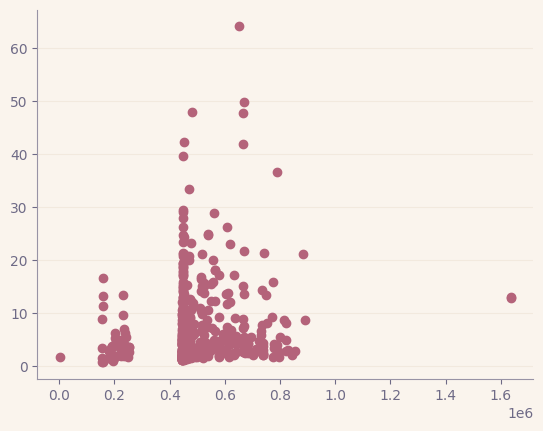

In [35]:
plt.scatter(x, y)

**Attempt 1 Conclusion**: my total line method does not reliably predict the loading time.
- My hypothesis is that imports dominate the line count and many theorems (and files) share similar imports
- To improve this method, I would need to know more about how lean or `lake` handles imports
- I don't really want to invest the time learning that so instead, I'll try something simpler: just the starting position in the file

Attempt 1.5: Sanity Check against a simpler method of just the starting line:

In [39]:
z = [thm["start"][0] for thm in thms.values() if thm.get("entry_time", None) is not None]

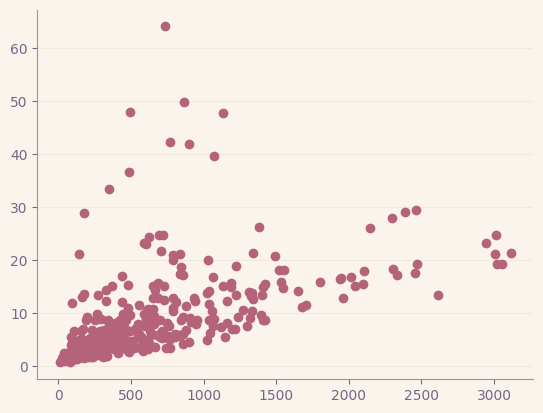

In [40]:
plt.scatter(z, y)

## Now with larger timing sample (4096 theorems)

In [6]:
data_path = project_root / "data/timing/final.json"
with open(data_path) as f:
    timing_data = json.load(f)

In [9]:
dummy_idx = next(iter(timing_data["theorems"]))
dummy_thm = timing_data["theorems"][dummy_idx]
dummy_thm

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': 'fe4454af900584467d21f4fd4fe951d29d9332a7',
 'file_path': 'Mathlib/Data/Matroid/Dual.lean',
 'full_name': 'Matroid.ground_not_base',
 'start': [212, 1],
 'end': [213, 65],
 'traced_tactics': [{'tactic': 'rwa [rkPos_iff_empty_not_base, dual_base_iff, diff_empty] at h',
   'annotated_tactic': ['rwa [<a>rkPos_iff_empty_not_base</a>, <a>dual_base_iff</a>, <a>diff_empty</a>] at h',
    [{'full_name': 'Matroid.rkPos_iff_empty_not_base',
      'def_path': 'Mathlib/Data/Matroid/Basic.lean',
      'def_pos': [240, 9],
      'def_end_pos': [240, 33]},
     {'full_name': 'Bool.true',
      'def_path': '.lake/packages/lean4/src/lean/Init/Prelude.lean',
      'def_pos': [567, 5],
      'def_end_pos': [567, 9]},
     {'full_name': 'Set.diff_empty',
      'def_path': 'Mathlib/Data/Set/Basic.lean',
      'def_pos': [1889, 9],
      'def_end_pos': [1889, 19]}]],
   'state_before': 'α : Type u_1\nM✝ : Matroid α\nI B X : Set α\nM : Ma

In [7]:
start_lines = []
entry_times = []
for idx, theorem in timing_data["theorems"].items():
    if "entry_time" not in theorem:
        continue
    entry_times.append(theorem["entry_time"])
    start_lines.append(theorem["start"][0])

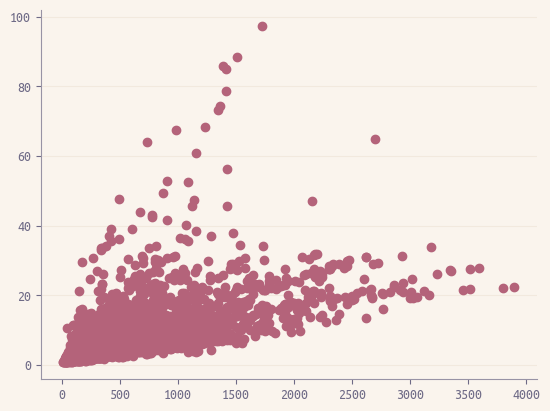

In [6]:
plt.scatter(start_lines, entry_times)

In [10]:
# compute correlation between start line and entry time
corr_coef = np.corrcoef(start_lines, entry_times)[0, 1]

In [8]:
# linear regression
from sklearn.linear_model import LinearRegression
# make a linear model
model = LinearRegression()
# fit the model
model.fit(np.array(start_lines).reshape(-1, 1), entry_times)
# get the model parameters
model.coef_, model.intercept_

(array([0.00947387]), 2.4047951951038993)

Text(0.5, 1.0, 'correlation coef: 0.65')

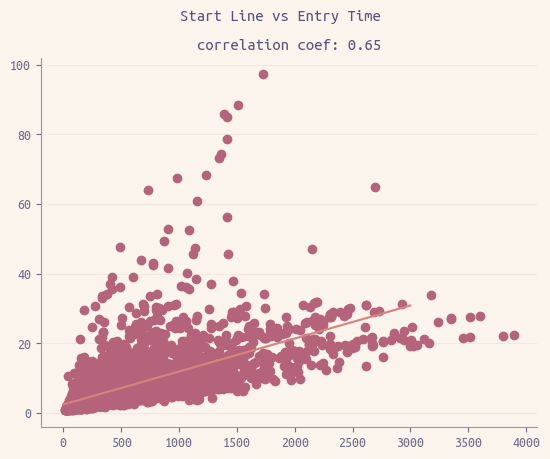

In [11]:
# scatter plot with best fit line
plt.scatter(start_lines, entry_times)
x = np.linspace(0, 3000, 100)
y = model.coef_ * x + model.intercept_
plt.plot(x, y, color="C2")
plt.suptitle("Start Line vs Entry Time")
plt.title(f"correlation coef: {corr_coef:.2f}")

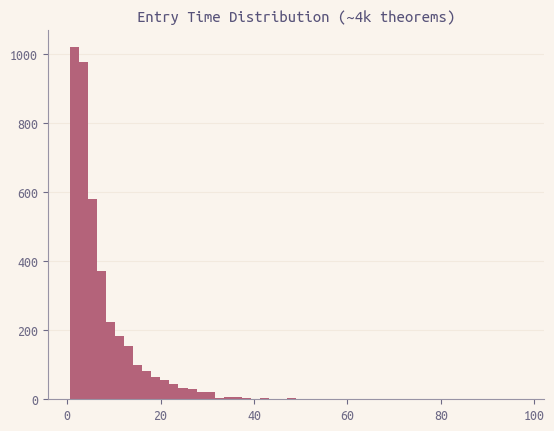

In [36]:
# histogram of entry times
plt.hist(entry_times, bins=50)
plt.title("Entry Time Distribution (~4k theorems)")
plt.savefig("../figures/entry_time_distribution.png")

In [9]:
# function to determine what proportion of dataset is under a threshold
def proportion_under_threshold(data, threshold):
    assert isinstance(data, np.ndarray)
    return np.sum(data < threshold) / len(data)

In [10]:
entry_times = np.array(entry_times)
print(proportion_under_threshold(entry_times, 5))
print(proportion_under_threshold(entry_times, 7))
print(proportion_under_threshold(entry_times, 8))
print(proportion_under_threshold(entry_times, 10))
print(proportion_under_threshold(entry_times, 20))

0.5410531569752932
0.6683304217619166
0.7169952582979785
0.7851260294484652
0.9371100573995508


In [11]:
threshold_times = list(range(1, 10)) + [10, 20, 30]
for threshold in threshold_times:
    print(f"proportion under {threshold}: {proportion_under_threshold(entry_times, threshold):.2f}")

proportion under 1: 0.01
proportion under 2: 0.15
proportion under 3: 0.32
proportion under 4: 0.44
proportion under 5: 0.54
proportion under 6: 0.61
proportion under 7: 0.67
proportion under 8: 0.72
proportion under 9: 0.76
proportion under 10: 0.79
proportion under 20: 0.94
proportion under 30: 0.98


In [59]:
with open("start_line_entry_time_lin_reg.json", 'w') as f:
    json.dump({
        "coef": model.coef_.item(),
        "intercept": model.intercept_,
        "correlation_coef": corr_coef
    }, f, indent=4)

#### Checking results for stability
On repeat runs,
- do we see the same errors?
- similar entry times?

In [62]:
print(timing_data["total_error_count"])

1065


In [69]:
error_data = timing_data["errors"]
error_counts = {
    k: len(v) for k, v in error_data.items()
}
print(json.dumps(error_counts, indent=2))

{
  "OTHER_ENTRY_ERROR": 89,
  "EOF": 89,
  "MISMATCH_BEFORE": 887,
  "SIMULATED_PROOF_UNFINISHED": 22,
  "OTHER_TACTICS_ERROR": 54,
  "'ProofFinished' object has no attribute 'pp'": 54,
  "MISMATCH_AFTER": 9,
  "BOTH_PROOFS_UNFINISHED": 4
}


In [5]:
# import lean_dojo
# - requires git version >= 2.25
#   - requires adding `/home/msho/.local/bin` to PATH
# prepend /home/msho/.local/bin to original PATH
# - make sure to use path sep
# - requires GH auth token
#   - import load_gh_authentication_token() from scripts directory
#     - requires adding the scripts directory to the path

if "_environment_variable_path_backup" not in globals():
    _environment_variable_path_backup = os.environ["PATH"]
    print("saved PATH")
else:
    print("original PATH already saved to _environment_variable_path_backup")
os.environ["PATH"] = (
    # prepend
    "/home/msho/.local/bin" + os.pathsep 
    + _environment_variable_path_backup
    # append
    + os.pathsep + "/home/msho/.elan/bin" 
)

sys.path.append(str(project_root))
from proof_flow.src.utils import prepare_environment_for_lean_dojo
prepare_environment_for_lean_dojo()

from lean_dojo import (
    InitOptimizedDojo, 
    Theorem, 
    LeanGitRepo,
    ProofFinished,
    TacticState,
    DojoHardTimeoutError,
)

saved PATH


/mnt/hdd/msho/miniconda3/envs/gfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-13 08:03:12,374	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [14]:
start = perf_counter()
example_theorem = next(iter(timing_data["theorems"].values()))
mathlib_repo = LeanGitRepo(example_theorem["url"], example_theorem["commit"])
print(f"constructed LeanGitRepo in {perf_counter() - start}s")
# - set tmp_dir
InitOptimizedDojo.default_tmp_dir = project_root / "tmp"

constructed LeanGitRepo in 10.311717404983938s


In [23]:
def time_thm_entry(thm_info, repo=mathlib_repo, timeout=60):
    thm = Theorem(repo, thm_info["file_path"], thm_info["full_name"])
    start = perf_counter()
    with InitOptimizedDojo(thm, hard_timeout=timeout) as (dojo, initial_state):
        entry_time = perf_counter() - start
    return entry_time

In [26]:
# out of laziness: "index to theorem dict" and "index to theorem"
i2td = lambda idx: timing_data["theorems"][str(idx)]
def i2t(idx):
    td = i2td(idx)
    return Theorem(mathlib_repo, td["file_path"], td["full_name"])

Checking EOF error...

In [92]:
print(error_data["EOF"])

[9012, 9115, 11149, 25427, 24411, 3655, 9779, 2245, 8067, 4286, 17877, 5216, 7457, 9840, 9688, 10559, 14476, 22739, 13356, 4182, 8524, 11377, 8850, 22629, 8988, 1973, 7585, 16180, 11854, 4984, 1213, 20681, 9674, 23997, 13022, 7796, 23335, 11106, 4263, 15800, 5424, 22163, 27233, 23119, 26014, 10341, 26719, 24683, 5913, 23816, 13042, 14585, 5609, 25131, 12587, 12907, 23638, 10651, 17218, 10281, 15062, 22718, 5897, 14697, 11395, 9846, 6662, 15278, 7537, 1108, 4505, 21603, 20308, 8759, 13005, 12224, 10855, 21648, 8247, 23622, 22665, 22267, 18345, 21538, 5511, 14387, 15022, 533, 24505]


In [107]:
i2td(9012)

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': 'fe4454af900584467d21f4fd4fe951d29d9332a7',
 'file_path': '.lake/packages/std/Std/Data/List/Lemmas.lean',
 'full_name': 'List.IsInfix.trans',
 'start': [2178, 1],
 'end': [2179, 95],
 'traced_tactics': [{'tactic': 'simp only [append_assoc]',
   'annotated_tactic': ['simp only [<a>append_assoc</a>]',
    [{'full_name': 'List.append_assoc',
      'def_path': '.lake/packages/lean4/src/lean/Init/Data/List/Basic.lean',
      'def_pos': [143, 9],
      'def_end_pos': [143, 21]}]],
   'state_before': 'α : Type u_1\nl l₁ r₁ l₂ r₂ : List α\n⊢ l₂ ++ l₁ ++ l ++ (r₁ ++ r₂) = l₂ ++ (l₁ ++ l ++ r₁) ++ r₂',
   'state_after': 'no goals'}]}

In [108]:
# EOF theorem
time_thm_entry(i2td(9012))

DojoInitError: EOF

Checking the unknown tactics error (ProofFinished object has no `pp` attribute)

In [110]:
error_data["OTHER_TACTICS_ERROR"][:10]

[22549, 14038, 14867, 1898, 2326, 13338, 24692, 5294, 11948, 25181]

In [111]:
time_thm_entry(i2td(22549))

6.250156853348017

In [112]:
i2td(22549)

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': 'fe4454af900584467d21f4fd4fe951d29d9332a7',
 'file_path': 'Mathlib/Algebra/Homology/HomotopyCategory/HomComplex.lean',
 'full_name': 'CochainComplex.HomComplex.Cochain.comp_zero',
 'start': [340, 1],
 'end': [344, 67],
 'traced_tactics': [{'tactic': 'ext p q hpq',
   'annotated_tactic': ['ext p q hpq', []],
   'state_before': 'C : Type u\ninst✝³ : Category.{v, u} C\ninst✝² : Preadditive C\nR : Type u_1\ninst✝¹ : Ring R\ninst✝ : Linear R C\nF G K L : CochainComplex C ℤ\nn m n₁ n₂ n₁₂ : ℤ\nz₁ : Cochain F G n₁\nh : n₁ + n₂ = n₁₂\n⊢ z₁.comp 0 h = 0',
   'state_after': 'case h\nC : Type u\ninst✝³ : Category.{v, u} C\ninst✝² : Preadditive C\nR : Type u_1\ninst✝¹ : Ring R\ninst✝ : Linear R C\nF G K L : CochainComplex C ℤ\nn m n₁ n₂ n₁₂ : ℤ\nz₁ : Cochain F G n₁\nh : n₁ + n₂ = n₁₂\np q : ℤ\nhpq : p + n₁₂ = q\n⊢ (z₁.comp 0 h).v p q hpq = 0.v p q hpq'},
  {'tactic': 'simp only [comp_v _ _ h p _ q rfl (by omega), zero_v, comp_z

In [143]:
def _run_tacs_helper(dojo, initial_state, tacs):
    # returns
    tactic_times = []
    state = initial_state
    errs = {}
    info = {
        "total_tactics": len(tacs),
        "tactic_errors": errs,
        "tactic_times": tactic_times
    }
    print(f"total tactics: {len(tacs)}")
    for i, tt_ in enumerate(tacs):
        print("on tactic idx", i)
        if state.pp != tt_["state_before"]:
            err = {
                "type": "before mismatch",
                "sim": state.pp,
                "dict": tt_["state_before"]
            }
            errs[i] = err
        start = perf_counter()
        res = dojo.run_tac(state, tt_["tactic"])
        tactic_times.append(perf_counter() - start)
        if isinstance(res, TacticState):
            if res.pp != tt_["state_after"]:
                err = {
                    "type": "after mismatch",
                    "sim": res.pp,
                    "dict": tt_["state_after"]
                }
                errs[i] = err
        else:
            if not isinstance(res, ProofFinished):
                if tt_["state_after"] != "no goals":
                    print("both unfinished")
                errs[i] = {
                    "type": "unfinished",
                    "sim": res,
                    "dict": tt_["state_after"]
                }
            if tt_["state_after"] != "no goals":
                errs[i] = {
                    "type": "unfinished",
                    "sim": res,
                    "dict": tt_["state_after"]
                }
    return info 

def run_tacs(thm_idx):
    with InitOptimizedDojo(i2t(thm_idx), hard_timeout=60) as (dojo, initial_state):
        res = _run_tacs_helper(dojo, initial_state, i2td(thm_idx)["traced_tactics"])
    return res

In [127]:
run_tacs(22549)

total tactics: 3
on tactic idx 0
on tactic idx 1
on tactic idx 2


AttributeError: 'ProofFinished' object has no attribute 'pp'

Tactics error seems to be due to an early completion (i.e. the tactic trace includes extra tactics)

Next, the mismatch error

In [124]:
# next is mismatch before
error_data["MISMATCH_BEFORE"][:10]

[8024, 22174, 976, 3070, 16559, 14719, 25018, 17571, 12403, 2279]

In [130]:
run_tacs(8024)

total tactics: 2
on tactic idx 0
on tactic idx 1
mismatch before:
state.pp:
-----
R : Type u_1
inst✝ : CommSemiring R
I : Ideal R
hI : Ideal.IsPrime I
hMin : I ∈ minimalPrimes R
x : Localization (Ideal.primeCompl I)
⊢ (∀ (J : Ideal (Localization (Ideal.primeCompl I))), Ideal.IsPrime J → x ∈ J) ↔
    x ∈ LocalRing.maximalIdeal (Localization (Ideal.primeCompl I))
-----
tt_["state_before"]:
------
R : Type u_1
inst✝ : CommSemiring R
I : Ideal R
hI : Ideal.IsPrime I
hMin : I ∈ minimalPrimes R
x : Localization (Ideal.primeCompl I)
x✝¹ : x ∈ LocalRing.maximalIdeal (Localization (Ideal.primeCompl I))
J : Ideal (Localization (Ideal.primeCompl I))
x✝ : Ideal.IsPrime J
⊢ x ∈ J


In [134]:
error_data["MISMATCH_AFTER"][:10]

[17081, 5879, 14344, 15120, 5045, 26707, 10745, 18686, 7717]

In [145]:
mismatch_after_ex = run_tacs(17081)

total tactics: 3
on tactic idx 0
on tactic idx 1
on tactic idx 2


In [153]:
mismatch_after_ex["tactic_errors"][1]

{'type': 'after mismatch',
 'sim': 'k G : Type u\ninst✝¹ : CommRing k\nn : ℕ\ninst✝ : Monoid G\n⊢ (Functor.mapHomologicalComplex (forget₂ (Rep k G) (ModuleCat k)) (ComplexShape.down ℕ)).map (εToSingle₀ k G) ≫\n      (HomologicalComplex.singleMapHomologicalComplex (forget₂ (Rep k G) (ModuleCat k)) (ComplexShape.down ℕ) 0).hom.app\n        (Rep.trivial k G k) =\n    (forget₂ToModuleCatHomotopyEquiv k G).hom',
 'dict': 'case hfg\nk G : Type u\ninst✝¹ : CommRing k\nn : ℕ\ninst✝ : Monoid G\n⊢ (forget₂ (Rep k G) (ModuleCat k)).map ((εToSingle₀ k G).f 0) ≫\n      ((HomologicalComplex.singleMapHomologicalComplex (forget₂ (Rep k G) (ModuleCat k)) (ComplexShape.down ℕ)\n                  0).hom.app\n            (Rep.trivial k G k)).f\n        0 =\n    (forget₂ToModuleCatHomotopyEquiv k G).hom.f 0'}

In [151]:
ex1 = i2td(17081)
ex1

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': 'fe4454af900584467d21f4fd4fe951d29d9332a7',
 'file_path': 'Mathlib/RepresentationTheory/GroupCohomology/Resolution.lean',
 'full_name': 'groupCohomology.resolution.εToSingle₀_comp_eq',
 'start': [669, 1],
 'end': [676, 64],
 'traced_tactics': [{'tactic': 'ext1',
   'annotated_tactic': ['ext1', []],
   'state_before': 'k G : Type u\ninst✝¹ : CommRing k\nn : ℕ\ninst✝ : Monoid G\n⊢ (Functor.mapHomologicalComplex (forget₂ (Rep k G) (ModuleCat k)) (ComplexShape.down ℕ)).map (εToSingle₀ k G) ≫\n      (HomologicalComplex.singleMapHomologicalComplex (forget₂ (Rep k G) (ModuleCat k)) (ComplexShape.down ℕ) 0).hom.app\n        (Rep.trivial k G k) =\n    (forget₂ToModuleCatHomotopyEquiv k G).hom',
   'state_after': 'case hfg\nk G : Type u\ninst✝¹ : CommRing k\nn : ℕ\ninst✝ : Monoid G\n⊢ ((Functor.mapHomologicalComplex (forget₂ (Rep k G) (ModuleCat k)) (ComplexShape.down ℕ)).map (εToSingle₀ k G) ≫\n          (HomologicalComplex.

In [154]:
for tt in ex1["traced_tactics"]:
    print(tt["tactic"])

ext1
dsimp
simpa using (forget₂ToModuleCatHomotopyEquiv_f_0_eq k G).symm


In [152]:
mathlib_repo

LeanGitRepo(url='https://github.com/leanprover-community/mathlib4', commit='fe4454af900584467d21f4fd4fe951d29d9332a7')

**Conclusion regarding mismatch errors**

Several things: 
- mismatch errors should probably count under the umbrella of unfinished proof. In the run tactics routine, we return early on a mismatch
- these mismatch errors seem to come from a failure in tracing the proof
- I checked the example from group cohomology example, and found that the proof that is currently there (i.e. in the mathlib4 repo in the commit indicated by the up-to-date benchmark contains a correct proof that has slightly different tactics than what is stored in the benchmark's traced tactics)

*Interestingly, I found that there were significantly more mismatch errors than I anticipated-- 800 something*.
Ultimately, this signals that training directly on this dataset is not perfect due to these errors.

This is alright because our GFN method actually avoids that pitfall by sampling new solutions (doing RL stuff instead of SFT).

**Next Steps**

Last thing I need to do with this timing study is verify the repeatable of the timing results.
The plan is
1. select 3 random theorems from lowest quantile and top quantile of entry times
2. time them
3. compare to original times

In [16]:
thm_times = {
    int(idx): thm["entry_time"] 
    for idx, thm in timing_data["theorems"].items()
    if "entry_time" in thm
}

In [17]:
# first is to sort by entry time
thms_by_entry_time = sorted(thm_times.items(), key=lambda x: x[1])

In [19]:
def get_random_samples_from_extreme(sorted_data, quantile=0.1, n_samples=5, rng_seed=42):
    random.seed(rng_seed)
    lo_bound = int(len(sorted_data) * quantile)
    hi_bound = len(sorted_data) - lo_bound
    lo_samples = random.sample(sorted_data[:lo_bound], n_samples)
    hi_samples = random.sample(sorted_data[hi_bound:], n_samples)
    return lo_samples, hi_samples

In [21]:
lo_samples, hi_samples = get_random_samples_from_extreme(thms_by_entry_time)

In [22]:
lo_samples

[(3965, 1.6442820839583874),
 (18334, 1.16736179869622),
 (26108, 0.9082089271396399),
 (20538, 1.7169111017137766),
 (4562, 1.3783247359097004)]

In [31]:
def re_time_samples(idxs, repetitions=3):
    res = {}
    for idx in tqdm(idxs):
        res[idx] = [time_thm_entry(i2td(idx)) for _ in range(repetitions)]
    return res

In [28]:
lo_samples_re_timed = re_time_samples([e[0] for e in lo_samples])


In [29]:
lo_samples_re_timed

{3965: [1.683304637670517, 1.7276909798383713, 1.761589141562581],
 18334: [1.1828434513881803, 1.2196525419130921, 1.2045921832323074],
 26108: [0.882681405171752, 1.002736795693636, 0.9176196726039052],
 20538: [1.5908551951870322, 1.7386482870206237, 1.5934724006801844],
 4562: [1.4750163769349456, 1.4721817532554269, 1.5435381522402167]}

In [30]:
print({
    k: np.mean(v) for k, v in lo_samples_re_timed.items()
})

{3965: 1.7241949196904898, 18334: 1.2023627255111933, 26108: 0.9343459578230977, 20538: 1.6409919609626133, 4562: 1.4969120941435297}


Low times are consistent

In [32]:
hi_samples_re_timed = re_time_samples([e[0] for e in hi_samples])

100%|██████████| 5/5 [05:50<00:00, 70.10s/it]


In [33]:
hi_samples

[(8108, 19.380051164887846),
 (9139, 19.07536089979112),
 (18265, 17.67199029121548),
 (26365, 42.90736479219049),
 (19142, 17.331082665361464)]

In [34]:
hi_samples_re_timed

{8108: [19.770881401374936, 19.833126771263778, 19.411049681715667],
 9139: [18.98480508942157, 18.883922066539526, 18.763423674739897],
 18265: [17.81846648454666, 17.709241614677012, 17.795835905708373],
 26365: [42.96943536121398, 42.765712168067694, 43.121406997554004],
 19142: [17.33062814362347, 17.56273254659027, 17.373747481033206]}

**Timing consistency conclusion:** timing is consistent

### Inspecting Combined, Filtered File

In [2]:
combined_filtered = "../data/test_time_filter.json"
with open(combined_filtered, 'r') as f:
    combined_filtered_data = json.load(f)

In [3]:
len(combined_filtered_data)

662

In [7]:
with open("../data/timing/v2_n20k_p2.json") as f:
    data = json.load(f)
entry_time_distribution = []
has_entry_time = 0
has_none_entry_time = 0
for thm in data["theorems"].values():
    if "entry_time" in thm:
        has_entry_time += 1
        if thm["entry_time"] is None:
            has_none_entry_time += 1
    
    if thm.get("entry_time", None) is not None:
        entry_time_distribution.append(thm["entry_time"])

print(has_entry_time)
print(has_none_entry_time)

15897
15255


In [10]:
errors = data["errors"]

In [11]:
errors.keys()

dict_keys(['OTHER_ENTRY_ERROR', 'LEAN_ERROR', 'ENTRY_TIMEOUT', 'INCOMPLETE_PROOF'])

In [12]:
for k, v in errors.items():
    print(k, len(v))

OTHER_ENTRY_ERROR 14744
LEAN_ERROR 143
ENTRY_TIMEOUT 511
INCOMPLETE_PROOF 12


In [13]:
other_entry_errors = errors["OTHER_ENTRY_ERROR"]

In [31]:
eof_count = 0
err2_count = 0
err2s = []
for err in other_entry_errors:
    idx, msg = err
    if msg == "EOF":
        eof_count += 1
    elif "Errno 2" in msg:
        err2s.append(idx)
        err2_count += 1
print(eof_count, err2_count)

13 14731


In [34]:
print(" ".join([str(e) for e in err2s[:10]]))


20989 19216 25936 25418 18805 15458 25980 13436 2782 15271


In [17]:
other_entry_errors[:10]

[[20989,
  "[Errno 2] No such file or directory: 'Mathlib/SetTheory/Ordinal/Arithmetic.bak' -> 'Mathlib/SetTheory/Ordinal/Arithmetic.lean'"],
 [19216,
  "[Errno 2] No such file or directory: 'Mathlib/GroupTheory/Subgroup/Basic.bak' -> 'Mathlib/GroupTheory/Subgroup/Basic.lean'"],
 [25936,
  "[Errno 2] No such file or directory: 'Mathlib/Data/Set/Basic.bak' -> 'Mathlib/Data/Set/Basic.lean'"],
 [25418,
  "[Errno 2] No such file or directory: 'Mathlib/Data/List/Basic.bak' -> 'Mathlib/Data/List/Basic.lean'"],
 [18805,
  "[Errno 2] No such file or directory: 'Mathlib/Order/Filter/Basic.bak' -> 'Mathlib/Order/Filter/Basic.lean'"],
 [15458,
  "[Errno 2] No such file or directory: '.lake/packages/std/Std/Data/List/Lemmas.bak' -> '.lake/packages/std/Std/Data/List/Lemmas.lean'"],
 [25980,
  "[Errno 2] No such file or directory: 'Mathlib/Computability/TuringMachine.bak' -> 'Mathlib/Computability/TuringMachine.lean'"],
 [13436,
  "[Errno 2] No such file or directory: 'Mathlib/Data/Multiset/Basic.ba

In [18]:
with open("../data/timing/v1_n4096.json") as f:
    v1_data = json.load(f)


In [20]:
v1e = v1_data["errors"]

In [21]:
for k, v in v1e.items():
    print(k, len(v))   

OTHER_ENTRY_ERROR 89
EOF 89
MISMATCH_BEFORE 887
SIMULATED_PROOF_UNFINISHED 22
OTHER_TACTICS_ERROR 54
'ProofFinished' object has no attribute 'pp' 54
MISMATCH_AFTER 9
BOTH_PROOFS_UNFINISHED 4


(array([ 2.,  3.,  5.,  9., 17.,  5., 15., 15., 17., 15., 17., 26., 14.,
        21., 28., 23., 11., 19., 15., 12., 16., 23., 17., 15., 12., 19.,
        11.,  5., 13.,  6., 10., 18., 12.,  9., 18., 15., 11.,  8., 12.,
        12.,  5.,  9., 11.,  9.,  9., 10.,  6., 15.,  5., 12.]),
 array([0.84870992, 0.93192066, 1.01513141, 1.09834215, 1.18155289,
        1.26476364, 1.34797438, 1.43118512, 1.51439587, 1.59760661,
        1.68081735, 1.7640281 , 1.84723884, 1.93044958, 2.01366033,
        2.09687107, 2.18008181, 2.26329256, 2.3465033 , 2.42971404,
        2.51292478, 2.59613553, 2.67934627, 2.76255701, 2.84576776,
        2.9289785 , 3.01218924, 3.09539999, 3.17861073, 3.26182147,
        3.34503222, 3.42824296, 3.5114537 , 3.59466445, 3.67787519,
        3.76108593, 3.84429668, 3.92750742, 4.01071816, 4.09392891,
        4.17713965, 4.26035039, 4.34356114, 4.42677188, 4.50998262,
        4.59319337, 4.67640411, 4.75961485, 4.8428256 , 4.92603634,
        5.00924708]),
 <BarContainer

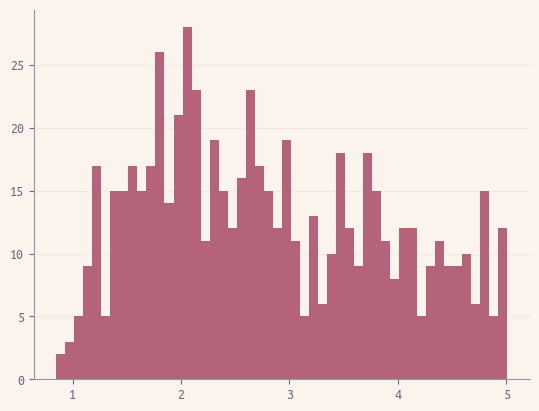

In [30]:
plt.hist(entry_time_distribution, bins=50)

In [6]:
len(entry_time_distribution)

642

In [22]:
with open("../data/timing/v2_n20k_p1.json") as f:
    v2_p1_data = json.load(f)

In [23]:
for k, v in v2_p1_data["errors"].items():
    print(k, len(v))

ENTRY_TIMEOUT 505
OTHER_ENTRY_ERROR 2833
LEAN_ERROR 130
INCOMPLETE_PROOF 15


In [24]:
e2c = 0
for idx, msg in v2_p1_data["errors"]["OTHER_ENTRY_ERROR"]:
    if "Errno 2" in msg:
        e2c += 1
print(e2c) 

2822


In [28]:
etc = 0
nnc = 0
for thm in v2_p1_data["theorems"].values():
    if "entry_time" in thm:
        etc += 1
        if thm["entry_time"] is None:
            nnc += 1
print(etc, nnc)

4001 3338
